# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**. <font color=red>I updated 'self.pose = ...self.init_pose' to '...self.init_pose***.copy()***'; that was a bug.</font>

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [3]:
import matplotlib.pyplot as plt
import random
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task


In [17]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        #return [new_thrust + random.gauss(0., 1.) for x in range(4)]
        return [new_thrust + x for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [52]:
%%time

%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 500.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 72.3 ms, sys: 12.2 ms, total: 84.6 ms
Wall time: 107 ms


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

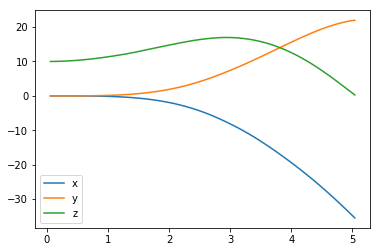

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

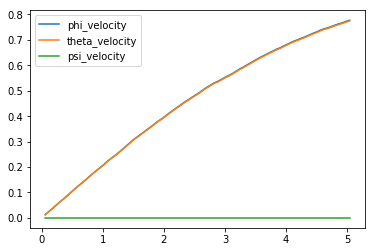

In [22]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

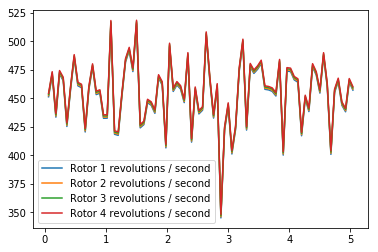

In [23]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent -- this is stochastic policy search

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

Episode = 10000, score = -481.688 (best = -352.029), noise_scale = 3 steps=23   CPU times: user 3min 34s, sys: 15.2 s, total: 3min 49s
Wall time: 3min 38s


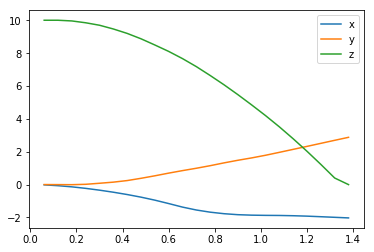

In [5]:
%%time

'''
didn't see improvment when num_episodes > 3000
linear s->a is too weak for this problem
reward doesn't make sense
'''
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 10000
target_pos = np.array([10., 10., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

score_, times_, xs_, ys_, zs_ = -np.inf, None, None, None, None

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    #print('episod ', i_episode, ' init pos: ', task.sim.pose)
    steps = 0
    times, xs, ys, zs = [], [], [], []
    while True:
        steps += 1
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        times.append(task.sim.time)
        xs.append(task.sim.pose[0])
        ys.append(task.sim.pose[1])
        zs.append(task.sim.pose[2])
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {} steps={} ".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale, steps), end="")  # [debug]
            break
    if agent.score > score_:
        score_, times_, xs_, ys_, zs_ = agent.best_score, times, xs, ys, zs

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(times, xs, label='x')
plt.plot(times, ys, label='y')
plt.plot(times, zs, label='z')
plt.legend()
_ = plt.ylim()


This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [1]:
%%time

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import numpy as np
from task import Task
from agents import agent

task = Task(target_z=25, init_z=10, init_z_velocity=0, runtime=512)
qmaxs, zs = agent.main(task, epochs=600, max_steps=256)

replay_buffer_size, state_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, actor_tau, critic_tau, batch_size
 128000 12 4 1000 0.01 0.1 0.99 0.1 0.1 32
epoch 10 steps 75 q max -18.329 xyz: -0.13, 0.22, 0.00 abc: 2.06, 3.96, 0.00
epoch 20 steps 75 q max -18.6428 xyz: -2.37, -1.00, 0.00 abc: 4.67, 3.41, 0.00
epoch 30 steps 68 q max -37.676 xyz: 2.79, -1.14, 0.00 abc: 5.37, 0.11, 0.00
epoch 40 steps 68 q max -31.5842 xyz: 2.22, -3.02, 0.00 abc: 5.92, 3.61, 0.00
epoch 50 steps 69 q max -35.2906 xyz: 1.49, 0.94, 0.00 abc: 0.91, 2.16, 0.00
epoch 60 steps 84 q max -43.0693 xyz: -2.72, -0.66, 0.00 abc: 0.66, 3.60, 0.00
epoch 70 steps 64 q max -49.7292 xyz: -1.33, 1.99, 0.00 abc: 2.52, 4.75, 0.00
epoch 80 steps 79 q max -28.2349 xyz: -1.03, -0.21, 0.00 abc: 5.42, 5.11, 0.00
epoch 90 steps 79 q max -40.311 xyz: -0.27, 0.04, 0.00 abc: 4.80, 0.83, 0.00
epoch 100 steps 71 q max -45.0048 xyz: -12.17, -1.62, 0.00 abc: 2.07, 2.57, 0.00
epoch 110 steps 42 q max 8.35372e+06 xyz: -8.97, 0.06, 0

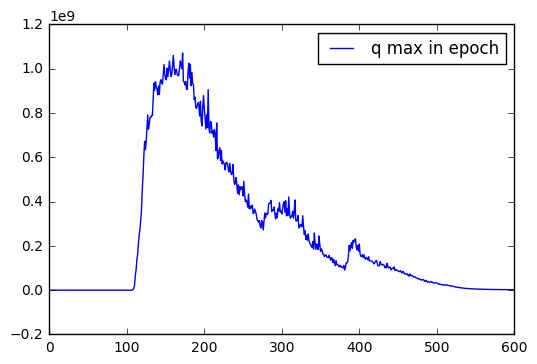

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(qmaxs, label='q max in epoch')
plt.legend()
_ = plt.ylim()

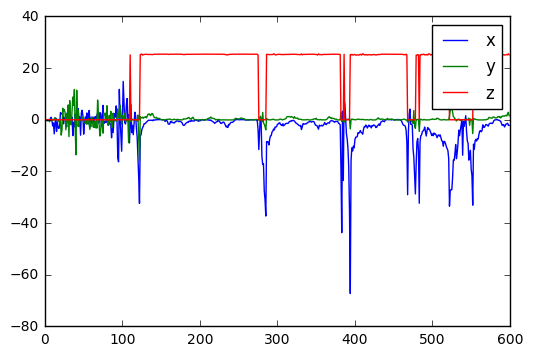

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
x,y,z, a,b,c = zip(*zs)
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(z, label='z')
#plt.plot(a, label='a')
#plt.plot(b, label='b')
#plt.plot(c, label='c')
plt.legend()
_ = plt.ylim()

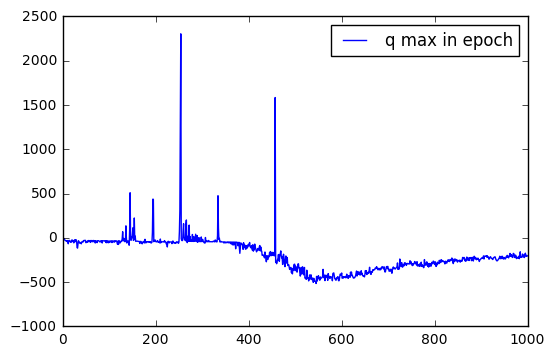

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(qmaxs, label='q max in epoch')
plt.legend()
_ = plt.ylim()

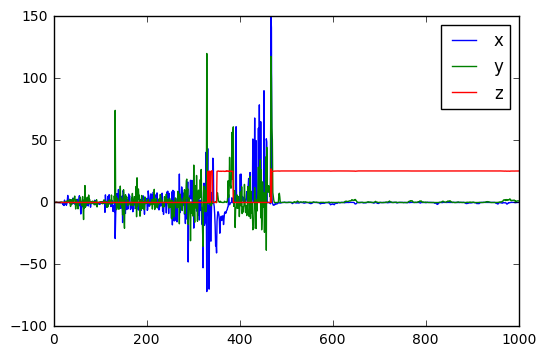

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
x,y,z, a,b,c = zip(*zs)
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(z, label='z')
#plt.plot(a, label='a')
#plt.plot(b, label='b')
#plt.plot(c, label='c')
plt.legend()
_ = plt.ylim()

<pre>
the last epoch:
epoch 990 steps 44 q max -182.63 xyz: 0.03, 1.82, 25.31 abc: 0.52, 6.22, 0.00
[  0.   0.  10.   0.   0.   0.   0.   0.   0.   0.   0.   0.] [[ -999.92092599   999.90402316   999.4933138   1000.68560881]] --> [  0.00000000e+00   0.00000000e+00   1.00100631e+01   2.97758919e-03
   5.98222012e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00630777e+00   1.09134581e-02  -1.54689626e-04   0.00000000e+00] -14.9899369223
[  0.00000000e+00   0.00000000e+00   1.00100631e+01   2.97758919e-03
   5.98222012e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00630777e+00   1.09134581e-02  -1.54689626e-04   0.00000000e+00] [[ -999.94824451   999.82402468   999.45961282  1000.72997853]] --> [ -7.18727749e-09   3.57738490e-05   1.00402416e+01   6.57703988e-03
   4.68853416e-05   0.00000000e+00  -7.18727749e-07   3.57738490e-03
   2.01154227e+00   2.25430437e-02  -1.56012069e-03   0.00000000e+00] -14.9597584219
[ -7.18727749e-09   3.57738490e-05   1.00402416e+01   6.57703988e-03
   4.68853416e-05   0.00000000e+00  -7.18727749e-07   3.57738490e-03
   2.01154227e+00   2.25430437e-02  -1.56012069e-03   0.00000000e+00] [[ -999.91482806   999.8613639    999.4267247   1000.66593995]] --> [ -5.83419827e-07   1.86137564e-04   1.00904938e+01   1.02452470e-02
   4.20246366e-05   0.00000000e+00  -5.69045272e-05   1.14589866e-02
   3.01368227e+00   3.38873749e-02  -2.58660418e-03   0.00000000e+00] -14.9095061765
... ... the quadcopter rotated, right?
</pre>

<font color=red>===================no GOING DOWN !!!</font>

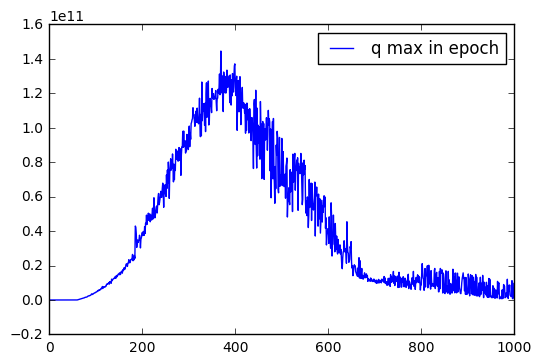

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(qmaxs, label='q max in epoch')
plt.legend()
_ = plt.ylim()

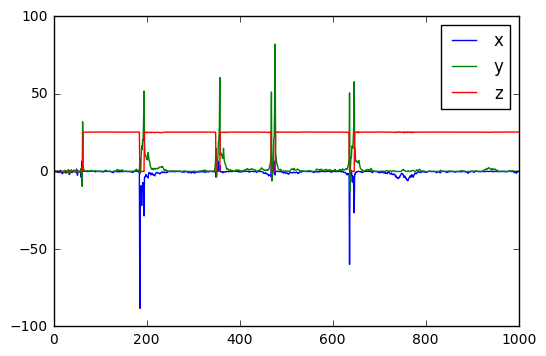

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
x,y,z, a,b,c = zip(*zs)
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(z, label='z')
#plt.plot(a, label='a')
#plt.plot(b, label='b')
#plt.plot(c, label='c')
plt.legend()
_ = plt.ylim()

<font color=red>===================no GOING DOWN !!!</font>

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

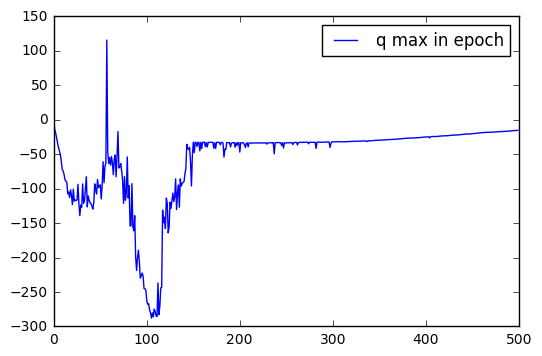

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(qmaxs, label='q max in epoch')
plt.legend()
_ = plt.ylim()

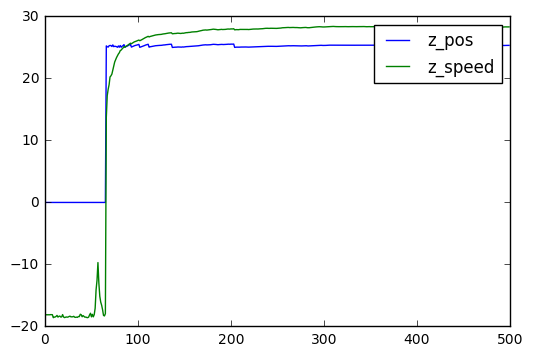

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
zs_pos, zs_speed = zip(*zs)
plt.plot(zs_pos, label='z_pos')
plt.plot(zs_speed, label='z_speed')
plt.legend()
_ = plt.ylim()

<pre>here are some details about this training:
replay_buffer_size, state_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, actor_tau, critic_tau, batch_size
128000 2 1 1000 0.01 0.1 0.99 actor_tau:0.01 critic_tau:0.01 32
epoch 20 steps 67 q max -98.2282 z_pos: 0.00, z_speed: -17.81   
epoch 40 steps 67 q max -98.9303 z_pos: 0.00, z_speed: -18.57   
epoch 60 steps 70 q max -51.021 z_pos: 25.25, z_speed: 17.58   
epoch 80 steps 44 q max -186.454 z_pos: 25.30, z_speed: 28.27   
epoch 100 steps 44 q max -77.767 z_pos: 25.38, z_speed: 28.38   
... ... 
(state, action) in the last epoch:
[ 10.   0.] [[-889.82685008]] --> [ 10.00755934   0.7559338 ] -14.992440662
[ 10.00755934   0.7559338 ] [[-889.90058557]] --> [ 10.03023334   1.51146688] -14.9697666552
[ 10.03023334   1.51146688] [[-890.01728553]] --> [ 10.06800377   2.26557533] -14.9319962332
... ...
[ 24.55772183  24.37095923] [[-891.21548613]] --> [ 25.04692482  24.54933987] 9.95307518046
epoch 500 steps 50 q max 12.8798 z_pos: 25.05, z_speed: 24.55   
CPU times: user 4min 40s, sys: 16.2 s, total: 4min 57s
Wall time: 2min 39s
</pre>

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
two reviewers told me to focus in z-space; i followed the instruction this time. so, state can be only (z_pos, z_speed); i could include other factors into state; but we know most of their values are 0s so that there is no back propogation of error terms for them -- except for z acceleration, but it seems like an internal variable to me, so i decided to leave it alone.
<br>the most important part in task.py is the reward function; thanks for previous reviewer showing me the popular reward function! certainly i used it in the training.
<br>in my training i found that +10 for >target_z is useless; we start from a lower position; when the quadcopter goes up, it already has an upwards velocity; we may think that increasing the Q value will tune up the action-value hyperspace -- which is true; however, in a simple simulation, the agent is stimulated to move up at full speed. after removing the extra reward i didn't see difference in training.
<br>i also tried another reward function: to award the agent if it moves *nearer* to target_z. the motivation is simple: critic evaluates q bases on (s, a)-- an action in the given state, the reward is given to the (s, a) but not a alone. the popular reward function is actually a state value -- action is not factored in.  
<br>my own reward function worked-- faster to find solutions but with worse performance. using the popular reward function (with or without extra reward on high z), the trained agent finishes one episode with 44 steps, but using my reward function, one episode succeeds with 71 steps. i guess the model got satisfied with early success too soon.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- actor critic. though for z-axis movement, simpler policy search algorithms should work as well; at first i used monte carlo policy gradient (MCPG) and two previous reviewers told me that it should work for this project; but i didn't follow their instructions to work on z-axis alone.  as i had discussed above, our reward function is actually a State value but not an Action value-- MCPG works on state value. So, mcpg should work in z-space too.
- finally: replay buffer is bigger enough to save all episode; hidden layer size can be as small as 2, while 4 is good enough; gamma > 0.9; learning rates for actor is 0.001 and for critic is 0.1; both taus are 0.1, batch size is 32... 
- i used two hidden layers in both actor and critic; i had tried 400 and 300 neurons in them, then reduced them to 100/75, 40/30, 8/8, 4/4, up to 2/2. I put batch normalization and relu in them, tanh for actor and linear for critic; random initializers in both network; Ornstein action noise; ... i am not sure whether anything is overkill. 
<br>say, i found that training converged faster without Ornstein action noise. using 2 neurons in each layer agent finished episode in 51 steps vs. using 8 neurons in each layer it finished episode in 44 steps;
<br>i also tried gamma: 1.0, 0.99, ... up to 0.8; when gamme==0.8, training finished after 260~300 epochs; when gamma=0.99 training finished around 100~120 epochs. so, smaller gamma might make agents too shortsighted -- while my best solution needs 41 steps: 0.8^10=0.107 vs. 0.9^10=0.349
<br>another interesting finding is about learning rate: actor 0.01 and critic 0.1 work! 0.001 and 0.01 did NOT; 0.01 and 0.01, worked 440 epoch at second time; so critic should learn faster with bigger lr; this is reflected in plots: after training succeeded, Q value changed, and then stayed stable. so, critic lags behind actor and needs a bigger learning rate to catch up
<br>i don't know how much i should generalize what i've seen in trainings.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
- the hardest in the course. in addition to the problem itself, challenge of using keras/tensorflow is big to me too. 
- it is a painful long curve.  real improvements only happened after i focused on reward function.
- it goes up as fast as it can. so training works. has to rewards, it is very stable around -28. i am using action_bound 1000; certainly if we have bigger scaled_out, the quadcopter can fly up faster, so it uses fewer steps to surpase target_z.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- the hardest part may be lack of a great starting point: a well implemented actor critic code that i can trusted, a successful training on another problem so that we can observe the performance curve, a complete document about the env so that i know the range of rotor speed--whether it can be negative? ... etc.  when training didn't improve --which happens so often-- i had *everything* to concern.
- *absolutely*. 